In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

### Load Dataset

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get newest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
9510,7720,31235,11.23.,강남구,-,감염경로 조사 중,NaN
16290,940,11696,6.05.,양천구,-,양천구 운동시설 관련,퇴원
4714,12616,44180,12.14.,강서구,-,강서구 교회 관련,NaN
15589,1641,14510,8.6.,용산구,미국,해외 접촉 추정,퇴원
16533,697,10946,5.10.,강서구,-,이태원 클럽 관련,퇴원
12765,4465,21545,9.08.,은평구,-,관악구 가족모임,퇴원
8789,8441,33003,11.27.,서대문구,-,중구 제조업공장 관련,NaN
14512,2718,16958,8.21.,도봉구,-,성북구 사랑제일교회 관련,퇴원
16764,466,10081,3.31.,관악구,미국,해외 접촉 추정,퇴원
11016,6214,27120,11.05.,관악구,-,서초구 빌딩 관련,퇴원


### Preprocessing for unknown contact record patients & known contact patients

In [9]:
# get two arrays of unknown route for contagion (미확인경로 확진자)
search_condition = (df_temp["접촉력"].str.contains("확인") | df_temp["접촉력"].str.contains("조사"))
array_unknown = df_temp.loc[search_condition,"접촉력"].unique()
array_unknown

array(['감염경로 조사중', '감염경로 확인중', '감염경로 조사 중', '확인 중', '확인중'], dtype=object)

In [10]:
# overwrite whatever cell value that contains "확인" as "확인 중"
for item in array_unknown:
    df_temp.loc[df_temp["접촉력"].str.contains(item),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array(['확인 중'], dtype=object)

In [11]:
# remove unnecessary labelings
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [63]:
# fix typos
df_temp["접촉력"] = df_temp["접촉력"].str.replace("확잔지", "확진자")
df_temp["접촉력"] = df_temp["접촉력"].str.replace("접촐", "접촉")
df_temp["접촉력"] = df_temp["접촉력"].str.replace("]", "")

In [64]:
infection_paths = df_temp["접촉력"].unique()
print("number of known contact paths:", len(infection_paths))
print(infection_paths)

number of known contact paths: 476
['동부구치소' '기타 확진자 접촉' '확인 중' '영등포구 소재 의료기관' '구로구 소재 요양병원' '타시도 확진자 접촉'
 '송파구 소재 장애인 생활시설' '용산구 소재 건설현장' '양천구 소재 요양시설' '강남구 소재 공기업' '강서구 교회'
 '금천구 소재 교회' '해외 유입' '중구 콜센터' '강동구 지인모임' '강남구 개인사저 경비팀' '종로구 소재 요양시설'
 '중구 소재 콜센터(한전SCS)' '타시도 확진다 접촉' '마포구 소재 보험회사' '해외유입' '노원구 병원'
 '동대문구 소재 교회' '중구 소재 직장' '강남구 소재 콜센터Ⅱ' '중구 소재 직장 (농협중앙회)' '동부 구치소'
 '성북구 종교시설(장암교회)' '중구 콜센터Ⅱ' '노원구 병원 (강북연세병원)' '종로구 소재 파고다타운' '-' '기타'
 '동대문구 지혜병원' '송파구 소재 병원(12월)' '중구 소재 직장(농협중앙회)' '서울동부구치소' '중구 콜센터 Ⅱ'
 '중랑구 소재 병원' '서초구 소재 병원' '용산구 음식점' '중구 소재 시장(남대문시장)' '서초구 사우나Ⅱ' '동작구 사우나'
 '동대문구 지헤병원' '구로구 소재 요양벙원' '마포구 홍대세교회' '광진구 소재 병원' '송파구 체육시설'
 '고려대학교 밴드동아리' '마포구 소재 노인복지시설' '성동구 소재 병원' '강남구 소재 마사지샵'
 '강서구 소재 댄스교습시설 연관 병원' '종로구 소재 음식점' '제주여행(퇴직교사)' '서초구 건설회사' '영등포구 소재 콜센터'
 '중랑구 실내체육시설Ⅱ' '강남구 어학원 Ⅰ' '구로구 소재 보험회사' '구로구 소재 고등학교' '영등포구 학원'
 '송파구 소재 교정시설' '노원구 소재 회사' '강북구 소재 교회' '아산병원' '여의도 순복음교회' '동대문구 체육시설'
 '강서구 댄스교습 시설' '강서구 댄스교습 연관 병원' '구로구 고등학교' '노원구 체육시설' '은평구 소재 역사'
 '마포구 홈쇼핑회사' '노원구 의

### Preprocessing dates

In [65]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,17430,56828,12.26.,기타,-,동부구치소,NaN
1,17429,56827,12.26.,기타,-,동부구치소,NaN
2,17428,56826,12.26.,기타,-,동부구치소,NaN
3,17427,56806,12.26.,기타,-,동부구치소,NaN
4,17426,56817,12.26.,기타,-,동부구치소,NaN


In [66]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,17430,56828,12-26,기타,-,동부구치소,NaN
1,17429,56827,12-26,기타,-,동부구치소,NaN
2,17428,56826,12-26,기타,-,동부구치소,NaN
3,17427,56806,12-26,기타,-,동부구치소,NaN
4,17426,56817,12-26,기타,-,동부구치소,NaN


In [67]:
# change dates according to datetime format
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date["확진일"] = df_date["확진일"].str.replace("010","10")
df_date["확진일"] = df_date["확진일"].str.replace("011","11")
df_date["확진일"] = df_date["확진일"].str.replace("012","12")
df_date["확진일"] = df_date["확진일"].str.replace("00","0")
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,17430,56828,2020-12-26,기타,-,동부구치소,NaN
1,17429,56827,2020-12-26,기타,-,동부구치소,NaN
2,17428,56826,2020-12-26,기타,-,동부구치소,NaN
3,17427,56806,2020-12-26,기타,-,동부구치소,NaN
4,17426,56817,2020-12-26,기타,-,동부구치소,NaN


In [69]:
df = df_date.copy()
df.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
14674,2556,16609,2020-08-20,광진구,-,타시도 확진자 접촉,퇴원
8201,9029,34904,2020-12-01,관악구,-,기타 확진자 접촉,퇴원
5242,12088,42578,2020-12-12,성북구,-,성동구 병원,퇴원
2375,15055,50849,2020-12-21,강남구,미국,해외유입,NaN
391,17039,55374,2020-12-25,양천구,-,기타 확진자 접촉,NaN


In [70]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,17430,56828,2020-12-26,기타,-,동부구치소,NaN
1,17429,56827,2020-12-26,기타,-,동부구치소,NaN
2,17428,56826,2020-12-26,기타,-,동부구치소,NaN
3,17427,56806,2020-12-26,기타,-,동부구치소,NaN
4,17426,56817,2020-12-26,기타,-,동부구치소,NaN


In [71]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
8409,8821,34366,2020-11-30,강남구,-,기타 확진자 접촉,NaN
3757,13573,46675,2020-12-17,동대문구,-,확인 중,NaN
11973,5257,23748,2020-09-29,서초구,-,확인 중,퇴원
16624,606,10526,2020-04-12,성동구,미국,해외 접촉 추정,퇴원
14776,2454,21531,2020-08-19,타시도,-,고대 안암병원,퇴원
10731,6499,27918,2020-11-11,도봉구,-,용산구 국군복지단,퇴원
1255,16175,54381,2020-12-24,강남구,-,기타 확진자 접촉,NaN
3786,13544,46660,2020-12-17,양천구,-,기타 확진자 접촉,NaN
12695,4535,21804,2020-09-10,서초구,-,확인 중,퇴원
12648,4582,21876,2020-09-10,서초구,-,기타 확진자 접촉,퇴원


In [72]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [73]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-12-24,552
1,2020-12-19,472
2,2020-12-25,467
3,2020-12-16,423
4,2020-12-17,397


In [74]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
294,2020-01-24,1
274,2020-01-30,3
278,2020-01-31,3
306,2020-02-02,1
290,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [75]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [76]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [77]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [78]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [79]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [80]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [81]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [82]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
7,17423,56843,2020-12-26,타시도,-,확인 중,NaN
8,17422,56842,2020-12-26,타시도,-,확인 중,NaN
14,17416,56716,2020-12-26,강서구,-,확인 중,NaN
16,17414,56269,2020-12-26,영등포구,-,확인 중,NaN
22,17408,56872,2020-12-26,강서구,-,확인 중,NaN
...,...,...,...,...,...,...,...
17174,56,1768,2020-02-25,은평구,-,확인 중,퇴원
17188,42,1370,2020-02-25,송파구,-,확인 중,퇴원
17191,39,924,2020-02-25,금천구,-,확인 중,퇴원
17192,38,907,2020-02-25,타시도,-,확인 중,퇴원


In [83]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,1
3,2020-02-28,2
4,2020-03-02,2
...,...,...
232,2020-12-22,161
233,2020-12-23,147
234,2020-12-24,100
235,2020-12-25,150


In [84]:
df_untracked_no = df_untracked_temp

In [85]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [86]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
323,2020-12-12,299.0,81.0
324,2020-12-13,219.0,53.0
325,2020-12-14,251.0,58.0
326,2020-12-15,378.0,149.0
327,2020-12-16,423.0,128.0
328,2020-12-17,397.0,126.0
329,2020-12-18,284.0,122.0
330,2020-12-19,472.0,85.0
331,2020-12-20,328.0,115.0
332,2020-12-21,317.0,88.0


In [90]:
# Guestimate number of infection contact paths, based on basic reproduction number as 1.5
list_infection_paths_no = []
R0 = 1.5
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/R0
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/R0

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[3265, 3347, 3455, 3562, 3692, 3761, 3842, 3945, 4120, 4238]


In [91]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [92]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
333,2020-12-22,375,161,3761
334,2020-12-23,319,147,3842
335,2020-12-24,552,100,3945
336,2020-12-25,467,150,4120
337,2020-12-26,361,120,4238


In [93]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail(10)

,date,new_confirmed,new_untracked,no_paths,new_no_paths
328,2020-12-17,397,126,3265,143.0
329,2020-12-18,284,122,3347,82.0
330,2020-12-19,472,85,3455,108.0
331,2020-12-20,328,115,3562,107.0
332,2020-12-21,317,88,3692,130.0
333,2020-12-22,375,161,3761,69.0
334,2020-12-23,319,147,3842,81.0
335,2020-12-24,552,100,3945,103.0
336,2020-12-25,467,150,4120,175.0
337,2020-12-26,361,120,4238,118.0


In [94]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [95]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [96]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{'sc': '2000-01-01', 'lc': '1999-11-25', 'w': 7, 'h': True, 'ht': '신정'},
 {'sc': '2000-01-02', 'lc': '1999-11-26', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-03', 'lc': '1999-11-27', 'w': 2, 'h': False, 'ht': ''},
 {'sc': '2000-01-04', 'lc': '1999-11-28', 'w': 3, 'h': False, 'ht': ''},
 {'sc': '2000-01-05', 'lc': '1999-11-29', 'w': 4, 'h': False, 'ht': ''},
 {'sc': '2000-01-06', 'lc': '1999-11-30', 'w': 5, 'h': False, 'ht': ''},
 {'sc': '2000-01-07', 'lc': '1999-12-01', 'w': 6, 'h': False, 'ht': ''},
 {'sc': '2000-01-08', 'lc': '1999-12-02', 'w': 7, 'h': False, 'ht': ''},
 {'sc': '2000-01-09', 'lc': '1999-12-03', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-10', 'lc': '1999-12-04', 'w': 2, 'h': False, 'ht': ''}]

In [97]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [98]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [99]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [100]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [101]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [102]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [103]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [104]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
333,2020-12-22,375,161,69.0,0,0
334,2020-12-23,319,147,81.0,0,0
335,2020-12-24,552,100,103.0,0,0
336,2020-12-25,467,150,175.0,1,1
337,2020-12-26,361,120,118.0,0,1


### Add Government Social Distancing Policy

In [105]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
328,2020-12-17,397,126,143.0,0,0,0
329,2020-12-18,284,122,82.0,0,1,0
330,2020-12-19,472,85,108.0,0,1,0
331,2020-12-20,328,115,107.0,0,1,0
332,2020-12-21,317,88,130.0,0,0,0
333,2020-12-22,375,161,69.0,0,0,0
334,2020-12-23,319,147,81.0,0,0,0
335,2020-12-24,552,100,103.0,0,0,0
336,2020-12-25,467,150,175.0,1,1,0
337,2020-12-26,361,120,118.0,0,1,0


In [106]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨
# 서울에서 12월 8일 0시부 사회적 거리두기 2.5단계 실시

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3
df_train.loc[(df_train["date"]>="2020-09-14"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-12-08"),"gov_policy"] = 3

In [107]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [108]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.928044,0.953681,-0.007812,0.656880
new_untracked,0.928044,1.000000,0.920340,-0.025984,0.601399
new_no_paths,0.953681,0.920340,1.000000,0.008092,0.612106
is_weekend,-0.007812,-0.025984,0.008092,1.000000,-0.001707
gov_policy,0.656880,0.601399,0.612106,-0.001707,1.000000


In [121]:
df_train[df_train["new_untracked"] > df_train["new_no_paths"]]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
38,2020-03-02,6,2,0.0,0,0,0
41,2020-03-05,1,1,0.0,0,0,0
45,2020-03-09,26,3,1.0,0,0,0
47,2020-03-11,17,4,0.0,0,0,0
52,2020-03-16,13,5,1.0,0,0,0
...,...,...,...,...,...,...,...
329,2020-12-18,284,122,82.0,0,1,3
331,2020-12-20,328,115,107.0,0,1,3
333,2020-12-22,375,161,69.0,0,0,3
334,2020-12-23,319,147,81.0,0,0,3


<AxesSubplot:>

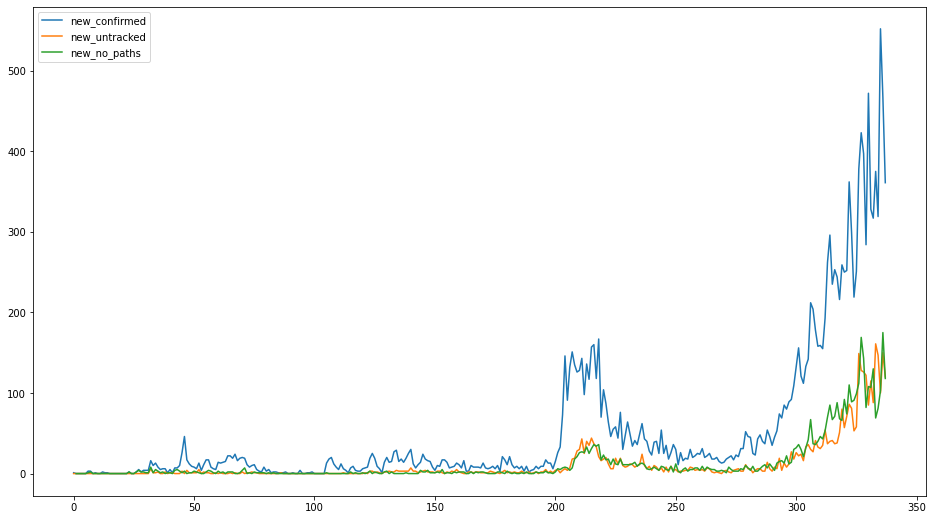

In [111]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

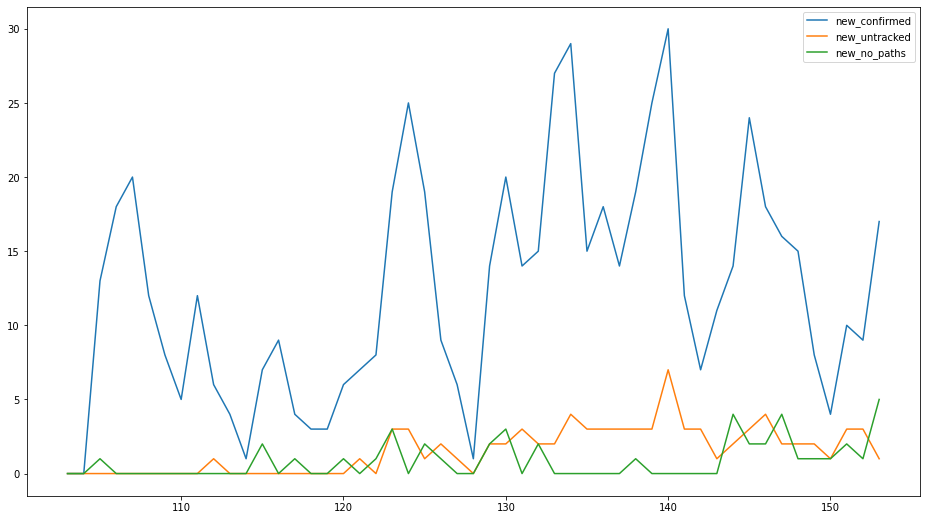

In [112]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


<AxesSubplot:>

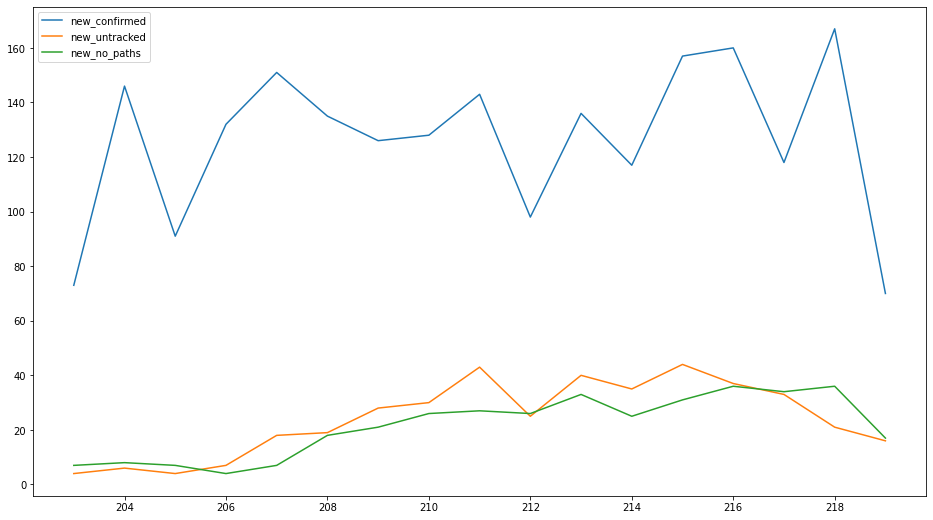

In [113]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14") & (df_train["date"]<="2020-08-30") ]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

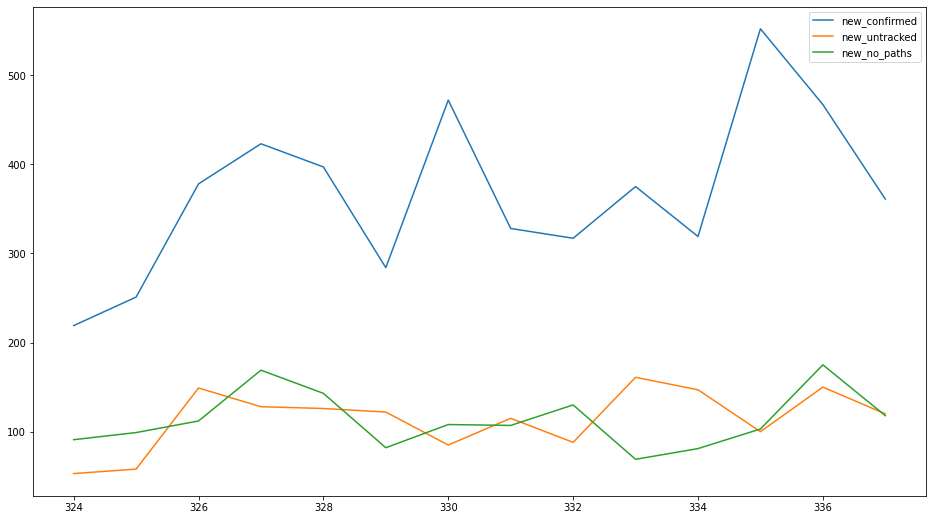

In [114]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

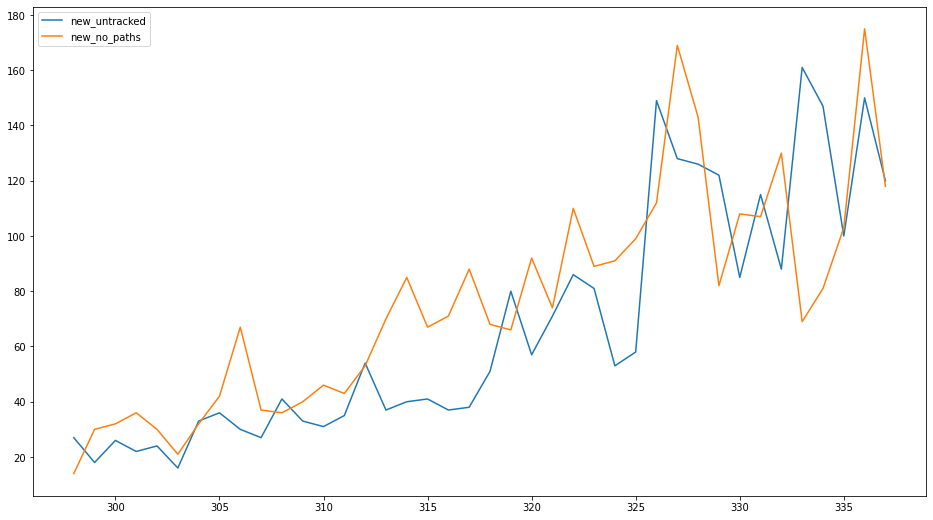

In [115]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
unknown_and_paths_graph = df_train[["new_untracked", "new_no_paths"]][-40:].plot(figsize=(16,9))
unknown_and_paths_graph

In [116]:
fig = unknown_and_paths_graph.get_figure()
fig.savefig('./img/unknown_and_paths_graph.png')